# Problem 1

## (a) Generating a distribution 
Generate the distribution:   
$$F(E) = k * E^{-\alpha} \exp\left(-\frac{E}{E_{c}}\right)$$
with $k = 1 \times 10^{-4} \, \text{s}^{-1} \text{cm}^{-2}$, $E_{c} = 81 \, \text{MeV}$, and $\alpha=1.87$.  
Note that the area of this function from 20 MeV to 500 MeV is $4.14575 \times 10^{-6}$. 

This is similar to how we sampled the weight functions in Homework 3, Problem 2. I will use the acceptance/rejection method to pull from this distribution. 

In [2]:
%matplotlib inline

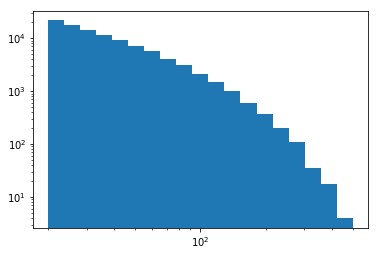

In [3]:
import numpy as np 
import matplotlib.pylab as plt

# Define a function to generate points with an arbitrary weighting function. 
# "Function" is my weight function
# "x_min" is the minimum x value
# "x_max" is the maximum x value
# "y_max" is the maximum y value of our function
# "N" is the desired number of points
def generator(function, x_min, x_max, y_min, y_max, N): 
    
    # Appending to arrays is slow. I create empty arrays, and assign the values as I go
    points_x = np.empty(N)
    points_y = np.empty(N)
    
    # Keep track of how many points I have accepted. 
    accepted = 0
    
    while accepted < N: 
        
        # Generate random x and y values
        # Uniform is inclusive on the first element, and excusive on the second. 
        # To cover my full range, I increase the upper bound by the smallest amount possible. 
        test_x = np.random.uniform(x_min, np.nextafter(x_max, x_max+1))
        test_y = np.random.uniform(y_min, np.nextafter(y_max, y_max+1))
        
        # Check if my random values "fit" my chosen probability distribution
        if test_y <= weight(test_x): 
            points_x[accepted] = test_x
            points_y[accepted] = test_y
            accepted += 1
            
    return points_x, points_y

weight = lambda x: (1/4.14575)*pow(10, 2) * pow(x, -1.87) * np.exp(-x/81)

minimum = weight(500)
maximum = weight(20)

sim_energies, unused_y = generator(weight, 20, 500, minimum, maximum, 100000)

plt.hist(sim_energies, bins=np.logspace(np.log10(20), np.log10(500), 20), log = True)
plt.gca().set_xscale("log")
plt.show()

## (b) Approximate the Fermi Point-Spread Function 
The PSF is a gaussian function in $X$ and $Y$. Use 100,000 points, with energy 100 MeV. 

In [4]:
# The standard deviation is energy dependent. 
sigma = lambda x: pow(x/100, -0.8)

# Two normal distributions centered at the appropriate center value
normal_x = lambda x, y: (1/np.sqrt(2 * np.pi * pow(y, 2))) * np.exp(-pow((x-48.04), 2) / (2 * pow(y, 2)))
normal_y = lambda x, y: 1/np.sqrt(2 * np.pi * pow(y, 2)) * np.exp(-pow((x+30.92), 2) / (2 * pow(y, 2)))

# I slightly modified the function from a) to work to generate positions. This is still just accept/reject. 
# It now takes two functions (the normal distribution, and standard deviation), a list of photon energies, and the 
# mean of the normal distribution. The function is greatest at the mean, and the maximum y value is needed 
# for the acceptance/rejection method. 
def position_generator(normal_func, sigma_func, energies, x_min, x_max, x_mid, y_min): 
    
    # Appending to arrays is slow. I create empty arrays, and assign the values as I go
    points_x = np.empty(len(energies))
    points_y = np.empty(len(energies))
    
    # Keep track of how many points I have accepted. 
    accepted = 0
    
    for ii in range(len(energies)): 
        energy = energies[ii]
        
        # getting the maximum y value 
        y_max = normal_func(x_mid, sigma_func(energy))
        while True: 
            # Generate random x and y values
            # Uniform is inclusive on the first element, and excusive on the second. 
            # To cover my full range, I increase the upper bound by the smallest amount possible. 
            test_x = np.random.uniform(x_min, np.nextafter(x_max, x_max+1))
            test_y = np.random.uniform(y_min, np.nextafter(y_max, y_max+1))

            # Check if my random values "fit" my chosen probability distribution
            if test_y <= normal_func(test_x, sigma_func(energy)): 
                points_x[ii] = test_x
                points_y[ii] = test_y
                break

            
    return points_x, points_y

# generating a list of energies
# They are all 100 MeV, for all 100,000 photons
energies = np.ones(100000)
energies = energies * 100

# Generate my datapoints
ra_points, unused_y  = position_generator(normal_x, sigma, energies, 20, 80, 48.04, 0)
dec_points, unused_y = position_generator(normal_y, sigma, energies, -50, -10, -30.92, 0)

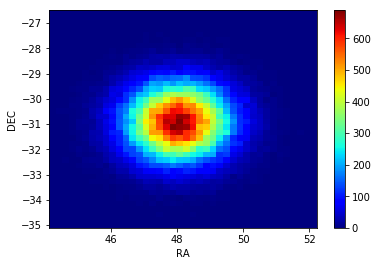

In [5]:
# Generating the data takes a long time compared to plotting it. 
# Placing this plotting code in a new notebook cell 
# lets me change the plot without recalculating all of the data. 

plt.hist2d(ra_points, dec_points, bins = 40, cmap = 'jet')
plt.colorbar()
plt.ylabel('DEC')
plt.xlabel('RA')
plt.show()

## (c) Simulating 100,000 photons 
The next step is to simulate/generate 100,000 photons with appropriate energies and positions.   
  
I already have a list of energies from part (a). From part (b), I have a function that takes those energies and generates appropriately distributed positions. Here, I combine the two. 

Note that the PSF changes with energy, so we cannot simply generate a 2-D Gaussian with 100,000 photons.

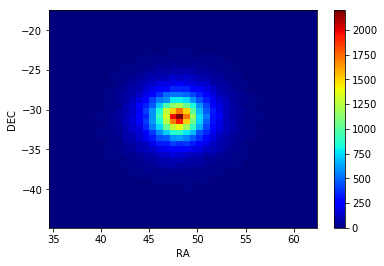

In [6]:
sim_ra, unused_y  = position_generator(normal_x, sigma, sim_energies, 20, 80, 48.04, 0)
sim_dec, unused_y = position_generator(normal_y, sigma, sim_energies, -50, -10, -30.92, 0)

plt.hist2d(sim_ra, sim_dec, bins = 40, cmap = 'jet')
plt.colorbar()
plt.ylabel('DEC')
plt.xlabel('RA')
plt.show()

## (d) Cut efficiency 

What cut would you need to make around the source's position to keep 95% of the data?  This is the kind of thing you might do to remove extraneous sources or focus in on a specific source.
  
I calculate the distance of each photon from the known center. I then sort this list, and take the distance corresponding to the 95000th photon. Thus, looking within this radius will keep 95% of the data. As a check, I draw a circle at this radius. 

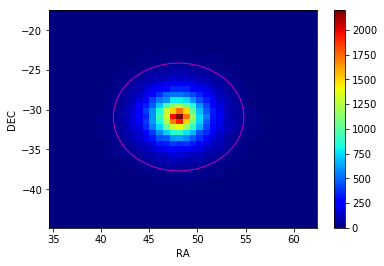

Keep all photons within 6.780545 degrees of center.


In [50]:
# calculate the distance. 
distance =  np.sort(np.sqrt(pow(sim_ra-48.04, 2) + pow(sim_dec+30.92, 2)))[94999]

# plot the circle 
circ_95 = plt.Circle((48.04, -30.92), distance, color='m', fill = False)
plt.hist2d(sim_ra, sim_dec, bins = 40, cmap = 'jet')
plt.colorbar()
ax = plt.gca()
ax.add_artist(circ_95)
plt.ylabel('DEC')
plt.xlabel('RA')
plt.show()

print ('Keep all photons within %f degrees of center.' % distance)

# Problem 2 

## (a) Scattering from atomic electrons

The problem is to find the solution for $E'$ in the equation
$$ \cos \phi = \frac{E^2 - E'^2 + K^2(1+ 2E_0/K)}{2EK \sqrt{1 + 2E_0/K}}$$
This is the same as finding the zero of the equation
$$\cos \phi - \frac{E^2 - E'^2 + K^2(1+ 2E_0/K)}{2EK \sqrt{1 + 2E_0/K}} = 0$$
(Note that it is possible to solve this simple equation algebraically, but that misses the entire point of the exercise.)

We will solve this equation using the bisection root-finding method.
It is not the fastest method, but it is robust and fast enough for this problem.
All units are keV.

In [49]:
def f(Eprime, E0):
    phi = 73/180*np.pi
    K = 2.5 # keV
    E = 100 # keV
    return np.cos(phi) - (E**2 - Eprime**2 + K**2*(1+2*E0/K)) / (2*E*K*np.sqrt(1+2*E0/K))

def bisection(E0, xminus, xplus, Nmax, eps):
    oldx = 0
    for it in range(0,Nmax):
        x=(xminus+xplus)/2
        print("iteration %2d: x = %.6f, Δ=%.6f, f(x) = %9.6f" % (it, x, abs(x-oldx), f(x, E0)))
        if (f(xplus, E0)*f(x, E0))>0:                      # Root in other half
            xplus=x
        else:
            xminus=x
        if(xplus-xminus<eps):                      # Converged?
            print("root found with precision eps = ",eps)
            break
        if it==Nmax-1:
             print("root not found after Nmax iterations ")   
        oldx = x
    return x  

E0 = 511 # keV
bisection(E0, 0., 1000., 100, 0.1)

iteration  0: x = 500.000000, Δ=500.000000, f(x) = 23.750622
iteration  1: x = 250.000000, Δ=250.000000, f(x) =  5.226173
iteration  2: x = 125.000000, Δ=125.000000, f(x) =  0.595061
iteration  3: x = 62.500000, Δ=62.500000, f(x) = -0.562717
iteration  4: x = 93.750000, Δ=31.250000, f(x) = -0.080309
iteration  5: x = 109.375000, Δ=15.625000, f(x) =  0.233256
iteration  6: x = 101.562500, Δ=7.812500, f(x) =  0.070443
iteration  7: x = 97.656250, Δ=3.906250, f(x) = -0.006441
iteration  8: x = 99.609375, Δ=1.953125, f(x) =  0.031624
iteration  9: x = 98.632812, Δ=0.976562, f(x) =  0.012498
iteration 10: x = 98.144531, Δ=0.488281, f(x) =  0.003005
iteration 11: x = 97.900391, Δ=0.244141, f(x) = -0.001724
iteration 12: x = 98.022461, Δ=0.122070, f(x) =  0.000639
iteration 13: x = 97.961426, Δ=0.061035, f(x) = -0.000543
root found with precision eps =  0.1


97.96142578125

We are fortunate that we can check this result against the analytic solution, but only because we can solve explicitly for $E'$:

In [46]:
def analytic_solution(E0):
    phi = 73/180*np.pi
    K  = 2.5
    E = 100
    minusEprime2 = (np.cos(phi)*2*E*K*np.sqrt(1+2*E0/K)) - E**2 - K**2*(1+2*E0/K)
    Eprime = np.sqrt(-minusEprime2)
    return Eprime

print("Analytic solution is", analytic_solution(511))

Analytic solution is 97.98945934262818


## (b) Scattering from nuclear protons

The only change to the scatterer mass, which is now 938,000 keV.

In [47]:
E0 = 938000 # keV
bisection(E0, 0., 3000., 100, 0.1)
print("Analytic solution is", analytic_solution(938000))

iteration  0: x = 1500.000000 and f(x) = -5.364163
iteration  1: x = 2250.000000 and f(x) =  1.129291
iteration  2: x = 1875.000000 and f(x) = -2.442109
iteration  3: x = 2062.500000 and f(x) = -0.737577
iteration  4: x = 2156.250000 and f(x) =  0.175565
iteration  5: x = 2109.375000 and f(x) = -0.286079
iteration  6: x = 2132.812500 and f(x) = -0.056525
iteration  7: x = 2144.531250 and f(x) =  0.059203
iteration  8: x = 2138.671875 and f(x) =  0.001260
iteration  9: x = 2135.742188 and f(x) = -0.027652
iteration 10: x = 2137.207031 and f(x) = -0.013201
iteration 11: x = 2137.939453 and f(x) = -0.005972
iteration 12: x = 2138.305664 and f(x) = -0.002356
iteration 13: x = 2138.488770 and f(x) = -0.000548
iteration 14: x = 2138.580322 and f(x) =  0.000356
root found with precision eps =  0.1
Analytic solution is 2138.544305860164


For now, we have taken the formula at face value.  We will not worry about where the extra energy comes from!

# Problem 3

The 3-dimensional Hamiltonian for the system is given as 

$$H = -\frac{1}{2} \frac{\partial^2}{\partial \rho^2} - \frac{1}{\rho} + \frac{\ell(\ell+1)}{2\rho^2}$$

with a trial function that depends only on $\rho$, since the hydrogen atom ground state is spherically symmetric

$$\Psi_T(\rho) = \alpha \rho e^{-\alpha \rho}$$

## (a) Derivation of $E_L$

To find $E_L$ for this specific combination of $H$ and $\Psi$, we'll calculate

$$E_L = \frac{1}{\Psi_T} H \Psi_T$$

The first step is to calculate $H\Psi_T$ (we'll drop the $T$ subscript for now):

$$
\begin{align}
H\Psi &= -\frac{1}{2} \frac{\partial^2}{\partial \rho^2}\Psi - \frac{1}{\rho}\Psi + \frac{\ell(\ell+1)}{2\rho^2}\Psi \\
&= -\frac{1}{2} \frac{\partial}{\partial \rho} \left[ \alpha e^{-\alpha\rho} - \alpha^2 \rho e^{-\alpha\rho} \right] \Psi - \frac{1}{\rho}\Psi + \frac{\ell(\ell+1)}{2\rho^2}\Psi \\
&= -\frac{1}{2} \left[ -\alpha^2 e^{-\alpha\rho} - \alpha^2 e^{-\alpha\rho} + \alpha^3 \rho e^{-\alpha\rho} \right] \Psi - \frac{1}{\rho}\Psi + \frac{\ell(\ell+1)}{2\rho^2}\Psi \\
&= \alpha^2 e^{-\alpha\rho}\Psi + -\frac{\alpha^3}{2} \rho e^{-\alpha\rho}\Psi - \frac{1}{\rho}\Psi + \frac{\ell(\ell+1)}{2\rho^2}\Psi \\
\end{align}
$$

Then after we divide out $\Psi$, we obtain the expression for $E_L$:

$$
E_L = \frac{\alpha}{\rho} - \frac{1}{2} \alpha^2 - \frac{1}{\rho} + \frac{\ell(\ell+1)}{2\rho^2}
$$

For the ground state, $\ell=0$, and the last term disappears, leaving

$$E_L = -\frac{1}{\rho} - \frac{\alpha}{2}\left( \alpha - \frac{2}{\rho} \right)$$

## (b) Numerical Results

To calculate the expectation value $\langle E_L \rangle$, we need to integrate $E_L$ with the probability weighting $\Psi^\ast \Psi = \alpha^2 \rho^2 e^{-2\alpha\rho}$.
The importance sampling for the integral can be done with the acceptance/rejection method or with the Metropolis algorithm.

The simple acceptance/rejection method will be inefficient for this exponential function, so we will use the Metropolis method instead.
(It also has the advantage that it can explore the infinite interval without a cutoff value.)
We need to know where the random walk should start on the interval $[0,\infty]$ and how big the trial step size should be.
To find some reasonable values, check the probability function for a reasonable value $\alpha=1$.

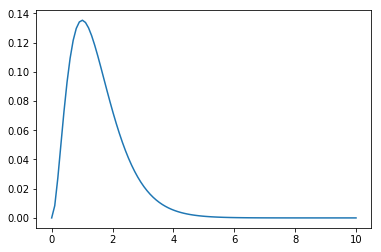

In [9]:
def P(rho, alpha):
    if rho > 0:
        return pow(alpha,2)*pow(rho,2)*np.exp(-2*alpha*rho)
    else:
        return 0

N = 100
rho_values = np.linspace(0, 10, N)
P_values = []
for rho in rho_values:
    P_values.append(P(rho, 1.0))
plt.plot(rho_values, P_values)
plt.show()

For the value $\alpha=1$, it looks like the maximum of the probability distribution is around 1.0, and an approximate "width" is also 1.  This gives us a hint about where to start the random walk and how to set the trial step size.
After running some tests with the code below, we find that a trial step size of 2.0 seems to give a trial success rate of 50%.

And after seeing the result with the Metropolis algorithm, we added the von Neumann algorithm, too, for comparison.

For alpha=0.400, MC efficiency is 10000 points in 12755 attempts: EL = -0.305
For alpha=0.500, MC efficiency is 10000 points in 13560 attempts: EL = -0.358
For alpha=0.600, MC efficiency is 10000 points in 14313 attempts: EL = -0.403
For alpha=0.700, MC efficiency is 10000 points in 15332 attempts: EL = -0.444
For alpha=0.800, MC efficiency is 10000 points in 16585 attempts: EL = -0.476
For alpha=0.900, MC efficiency is 10000 points in 17797 attempts: EL = -0.491
For alpha=1.000, MC efficiency is 10000 points in 18990 attempts: EL = -0.500
For alpha=1.100, MC efficiency is 10000 points in 20143 attempts: EL = -0.498
For alpha=1.200, MC efficiency is 10000 points in 21265 attempts: EL = -0.492
For alpha=1.300, MC efficiency is 10000 points in 22857 attempts: EL = -0.470
For alpha=1.400, MC efficiency is 10000 points in 23806 attempts: EL = -0.438
For alpha=1.500, MC efficiency is 10000 points in 25483 attempts: EL = -0.376
For alpha=1.600, MC efficiency is 10000 points in 27325 attempts

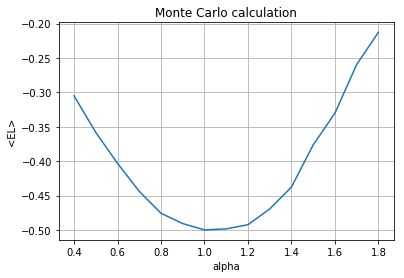

In [22]:
def EL(rho, alpha):
    # rho must be positive
    return -1./rho - alpha/2. * (alpha - 2./rho)


def metropolis(N, x0, alpha, w, delta):
    # x0 is the starting point for the random walk
    # alpha is the variable parameter, not the variable of integration
    # w is the target probability distribution 
    n_attempts = 0
    n_accepted = 0
    points = np.zeros(N)
    x = x0
    while n_accepted < N:
        n_attempts += 1
        x_trial = x + delta*np.random.uniform(-1., 1.)
        r = w(x_trial, alpha)/w(x, alpha)
        if r > np.random.random():
            # Step accepted
            points[n_accepted] = x_trial
            x = x_trial
            n_accepted += 1
    # Returns N points distributed according to w
    return (points, n_attempts)

def vonNeumann(N, xmin, xmax, ymin, ymax, w, alpha):
    n_attempts = 0
    n_accepted = 0
    points = np.zeros(N)
    while n_accepted < N:
        n_attempts +=1
        x_trial = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        if y < w(x_trial, alpha):
            points[n_accepted] = x_trial
            x = x_trial
            n_accepted += 1
    return (points, n_attempts)

N = 10000
delta = 2.0
alpha_values = []
EL_exp_values = []
for alpha in np.linspace(0.4, 1.8, 15):
    elsum = 0.
    (x_values, n_attempts) = metropolis(N, 1.5, alpha, P, delta)
    #(x_values, n_attempts) = vonNeumann(N, 0., 5., 0., 0.14, P, alpha)
    #plt.hist(x_values)
    #plt.show()
    for x in x_values:
        elsum += EL(x, alpha)
    result = elsum/N
    print("For alpha=%.3f, MC efficiency is %d points in %d attempts: EL = %.3f" 
          %(alpha, N, n_attempts, result))
    alpha_values.append(alpha)
    EL_exp_values.append(result)

plt.plot(alpha_values, EL_exp_values)
plt.xlabel('alpha')
plt.ylabel('<EL>')
plt.title("Monte Carlo calculation")
plt.grid()
plt.show()

The minimum energy occurs near $\alpha=1.0$, and the ground state energy is -0.5 in units of $e^2/4\pi\epsilon_0 a_0$.  This is $E_G = -0.5 * 27.21 = -13.6\,\text{eV}$, exactly what we already knew for the hydrogen atom.

The only mystery is why we don't find the clear minimum at exactly $\alpha=1.0$.  If we use the von Neumann method instead, then we do find the minimum a little more clearly at $\alpha=1.0$.

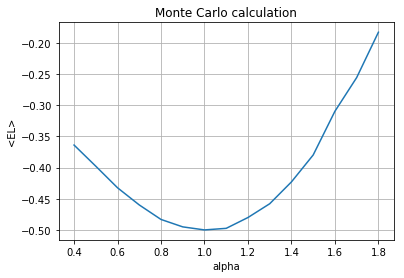

In [23]:
alpha_values = []
EL_exp_values = []
for alpha in np.linspace(0.4, 1.8, 15):
    elsum = 0.
    #(x_values, n_attempts) = metropolis(N, 1.5, alpha, P, delta)
    (x_values, n_attempts) = vonNeumann(N, 0., 5., 0., 0.14, P, alpha)
    for x in x_values:
        elsum += EL(x, alpha)
    result = elsum/N
    alpha_values.append(alpha)
    EL_exp_values.append(result)

plt.plot(alpha_values, EL_exp_values)
plt.xlabel('alpha')
plt.ylabel('<EL>')
plt.title("Monte Carlo calculation")
plt.grid()
plt.show()